In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Bước 1 - 2:
+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu training và testing.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [2]:

# Define the transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

# Download and load the CIFAR-10 testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Let's print some information to verify
print(f'Training dataset size: {len(trainset)}')
print(f'Testing dataset size: {len(testset)}')


Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 50000
Testing dataset size: 10000


+ Hiển thị 10 ảnh đầu tiên trong tập dữ liệu testing

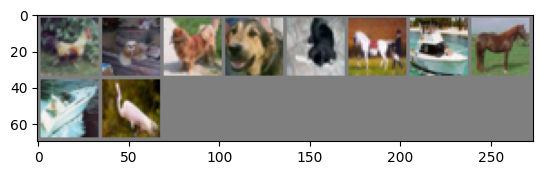

In [3]:
def imshow(img):
    img = img * 0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images[:10]))
    break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [4]:
def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    return model

+ Khởi tạo hàm loss function và phương thức optimizer

In [5]:
n_features = 32 * 32 * 3 
model = getModel(n_features)
lr = 0.01
optim = SGD(params = model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

+ Xây dựng hàm đánh giá model

In [6]:
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy


+ Bắt đầu training và đánh giá model.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, accuracy_score

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x

model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

n_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def evaluate(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_loss /= len(dataloader)
    return test_loss, accuracy

best_accuracy = 0.0

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
    
    scheduler.step()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.6335, Accuracy: 40.07%, Test Loss: 1.2612, Test Accuracy: 54.78%
Epoch [2/10], Loss: 1.3078, Accuracy: 52.72%, Test Loss: 1.0581, Test Accuracy: 62.20%
Epoch [3/10], Loss: 1.1683, Accuracy: 57.87%, Test Loss: 0.9483, Test Accuracy: 66.40%
Epoch [4/10], Loss: 1.0808, Accuracy: 61.55%, Test Loss: 0.8731, Test Accuracy: 68.89%
Epoch [5/10], Loss: 1.0210, Accuracy: 63.49%, Test Loss: 0.8714, Test Accuracy: 68.92%
Epoch [6/10], Loss: 0.9390, Accuracy: 66.71%, Test Loss: 0.7931, Test Accuracy: 72.01%
Epoch [7/10], Loss: 0.9185, Accuracy: 67.73%, Test Loss: 0.7805, Test Accuracy: 72.49%
Epoch [8/10], Loss: 0.9035, Accuracy: 68.18%, Test Loss: 0.7684, Test Accuracy: 72.86%
Epoch [9/10], Loss: 0.8887, Accuracy: 68.87%, Test Loss: 0.7603, Test Accuracy: 73.06%
Epoch [10/10], Loss: 0.8812, Accuracy: 68.92%, Test Loss: 0.7541, Test Accuracy: 73.47%


+ Biểu đồ sau khi train

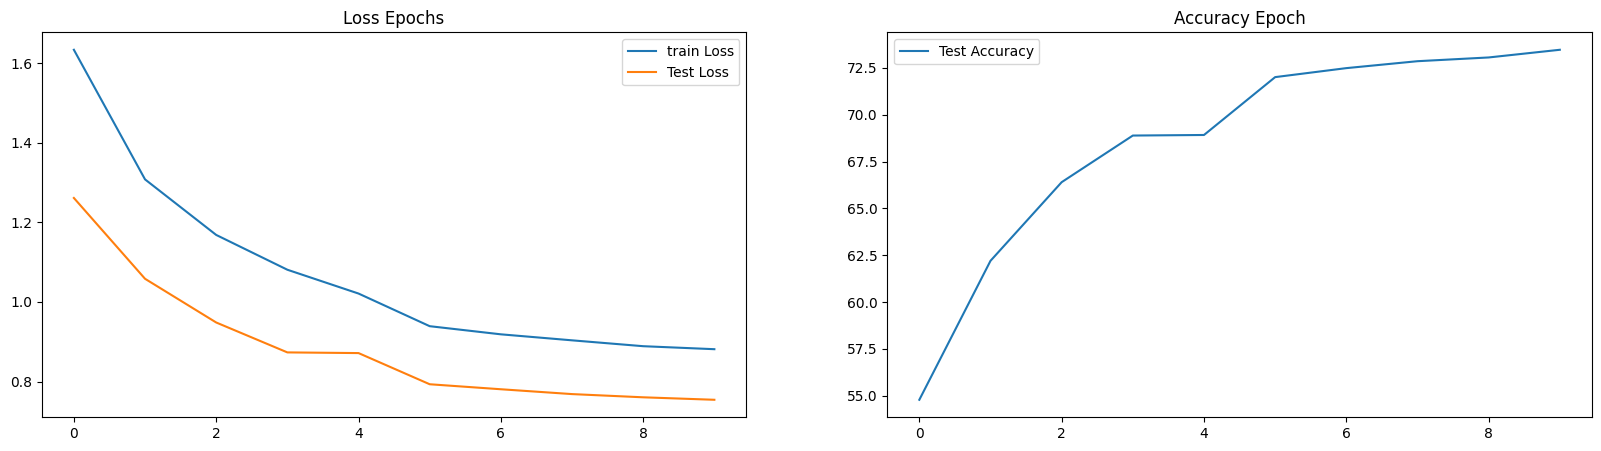

In [8]:
import matplotlib.pyplot as plt

# Assuming 'train_losses', 'test_losses', and 'test_accuracies' are already defined

plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label='train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()

plt.show()

Bước 3: Sử dụng 3 thuật toán khác nhau
+ Thuật toán SVM

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Chuyển đổi dữ liệu thành định dạng numpy
for data in trainloader:
    train_images, train_labels = data
    train_images = train_images.view(train_images.size(0), -1).numpy()
    train_labels = train_labels.numpy()

for data in testloader:
    test_images, test_labels = data
    test_images = test_images.view(test_images.size(0), -1).numpy()
    test_labels = test_labels.numpy()

# Định nghĩa mô hình SVM
svm_model = svm.SVC(kernel='linear', C=1.0)

# Huấn luyện mô hình SVM
svm_model.fit(train_images, train_labels)

# Dự đoán và tính toán Precision và Recall
svm_predictions = svm_model.predict(test_images)
svm_precision = precision_score(test_labels, svm_predictions, average='macro') * 100
svm_recall = recall_score(test_labels, svm_predictions, average='macro') * 100

print(f'SVM Precision: {svm_precision:.2f}%')
print(f'SVM Recall: {svm_recall:.2f}%')


SVM Precision: 22.50%
SVM Recall: 20.00%


C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+ Thuật toán Random Forest

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
import numpy as np

# Chuyển đổi dữ liệu thành định dạng numpy
for data in trainloader:
    train_images, train_labels = data
    train_images = train_images.view(train_images.size(0), -1).numpy()
    train_labels = train_labels.numpy()

for data in testloader:
    test_images, test_labels = data
    test_images = test_images.view(test_images.size(0), -1).numpy()
    test_labels = test_labels.numpy()

# Định nghĩa mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện mô hình Random Forest
rf_model.fit(train_images, train_labels)

# Dự đoán và tính toán Precision và Recall
rf_predictions = rf_model.predict(test_images)
rf_precision = precision_score(test_labels, rf_predictions, average='macro') * 100
rf_recall = recall_score(test_labels, rf_predictions, average='macro') * 100

print(f'Random Forest Precision: {rf_precision:.2f}%')
print(f'Random Forest Recall: {rf_recall:.2f}%')


Random Forest Precision: 5.56%
Random Forest Recall: 7.41%


C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


+ Thuật toán CNN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # Bổ sung import này
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score

# Định nghĩa mô hình CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Huấn luyện mô hình
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Lấy dữ liệu đầu vào; data là một danh sách [inputs, labels]
        inputs, labels = data

        # Xóa gradients
        optimizer.zero_grad()

        # Forward, backward, optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # In ra thông tin
        running_loss += loss.item()
        if i % 200 == 199:    # In ra mỗi 200 mini-batches
            print(f'[Epoch: {epoch + 1}, Mini-batch: {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

# Dự đoán và tính toán Precision và Recall
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

precision = precision_score(all_labels, all_preds, average='macro') *100
recall = recall_score(all_labels, all_preds, average='macro') *100

print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')


[Epoch: 1, Mini-batch: 200] loss: 2.304
[Epoch: 2, Mini-batch: 200] loss: 2.301
Finished Training
Precision: 7.94%
Recall: 13.66%


C:\Users\vuhuu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Bảng so sánh giữa các thuật toán
| Thuật toán   | Precision                                       | Recall  |
|--------------|-------------------------------------------------|---------|
| SVM          | 22.50%                                          | 20.00%  |
| Random Forest| 5.56%                                          | 7.41%  |
| CNN          | 7.94%                                          | 13.66%  |
